In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import csv
from sklearn.neural_network import MLPRegressor

import torch
import torch.nn as nn

import pickle
import re
import sys
from pathlib import Path
from matplotlib import pyplot as plt

import gensim
import nltk
import numpy as np
import pandas as pd
import scipy.sparse as ss
from corextopic import corextopic as ct
from gensim.utils import simple_preprocess
from tqdm.notebook import tqdm
from wordcloud import WordCloud

nltk.download('stopwords')
import sys
from pprint import pprint
from typing import List

import gensim.corpora as corpora
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

src_dir = Path("./")
sts_dir = Path("./stsbenchmark")
assert src_dir.exists()
output_dir = Path("data")
output_dir.mkdir(exist_ok=True, parents=True)

/home/iai/user/iser/.conda/envs/main/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iai/user/iser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_feather(data_dir / "df_lda.feather")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'df_lda.feather'

In [ ]:
model = MLPRegressor(
    (1024, 512, 256),
    max_iter=1_000,
)

In [29]:
X = np.concatenate([np.array(df.s1_lda.values.tolist()), np.array(df.s2_lda.values.tolist())], axis=1)
y = df.score

In [30]:
model.fit(X, y)

MLPRegressor(hidden_layer_sizes=(256, 256), max_iter=1000)

In [31]:
%%capture
df_test = pd.read_csv(sts_dir / 'sts-test.csv', error_bad_lines=False, header = None, delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
df_test = df_test.rename(columns={0: "genre", 1: "filename", 2: "year", 3: "trash", 4: "score", 5: "s1", 6: "s2"})
df_test.genre = df_test.genre.astype("category")
df_test.filename = df_test.filename.astype("category")
df_test.year = df_test.year.astype("category")
df_test.genre = df_test.genre.astype("category")

In [32]:
df_test

,genre,filename,year,trash,score,s1,s2
0,main-captions,MSRvid,2012test,24,2.5,A girl is styling her hair.,A girl is brushing her hair.
1,main-captions,MSRvid,2012test,33,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,main-captions,MSRvid,2012test,45,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,main-captions,MSRvid,2012test,63,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,main-captions,MSRvid,2012test,66,1.5,A man is playing a harp.,A man is playing a keyboard.
...,...,...,...,...,...,...,...
1090,main-news,headlines,2015,1438,0.4,"US, China fail to paper over cracks in ties",China: Relief in focus as hope for missing fades
1091,main-news,headlines,2015,1454,1.4,World Cup live: France 0-0 Germany,World Cup live: Germany 0-0 Ghana
1092,main-news,headlines,2015,1456,4.8,Tokyo to host 2020 Games,Tokyo wins race to host 2020 Olympic Games
1093,main-news,headlines,2015,1463,4.4,France warns of extremists benefiting from Egy...,France fears extremists will benefit from Egyp...


In [33]:
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

def preprocess(sentences: List[str]):
    sentences = map(lambda x: re.sub('[,\.!?]', '', x), sentences)
    sentences = map(lambda x: x.lower(), sentences)
    sentences = list(sent_to_words(sentences))
    sentences = remove_stopwords(sentences)
    return sentences

In [34]:
sent_1 = preprocess(df_test.s1.tolist())
sent_2 = preprocess(df_test.s2.tolist())

In [35]:
texts = sent_1 + sent_2
# Create Dictionary
id2word = corpora.Dictionary.load("id2word.pkl")
# Create Corpus
# Term Document Frequency
sent_1_corpus = [id2word.doc2bow(text) for text in sent_1]
sent_2_corpus = [id2word.doc2bow(text) for text in sent_2]

In [36]:
lda_model = gensim.models.LdaMulticore.load("lda_model.bin")

In [37]:
sent_1_lda = lda_model[sent_1_corpus]
sent_2_lda = lda_model[sent_2_corpus]

In [38]:
s1_lda = np.array([[prob[1] for prob in probs] for probs in tqdm(sent_1_lda)])
s2_lda = np.array([[prob[1] for prob in probs] for probs in tqdm(sent_2_lda)])

  0%|          | 0/1095 [00:00<?, ?it/s]

  0%|          | 0/1095 [00:00<?, ?it/s]

In [39]:
X_test = np.concatenate([s1_lda, s2_lda], axis=1)
X_test.shape

(1095, 32)

In [40]:
scores = model.predict(X_test)
scores.shape, scores[:10]

((1095,),
 array([0.5449415 , 0.66188943, 0.4253699 , 0.72546226, 0.8970026 ,
        0.74021196, 0.7093024 , 0.89421904, 0.51477873, 0.894222  ],
       dtype=float32))

In [41]:
pearsonr(scores, df_test.score / 5)

(0.3407205869053866, 3.6226115607100074e-31)

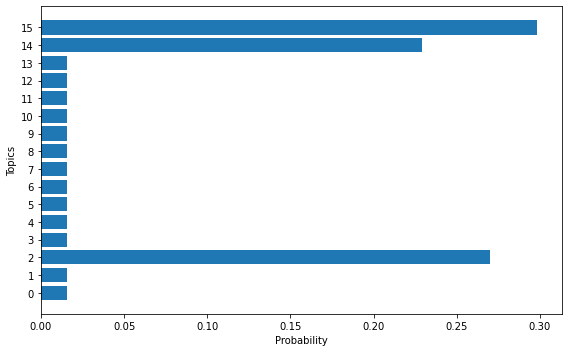

In [73]:
plt.figure(figsize=(8, 5), tight_layout=True)
plt.xlabel("Probability")
plt.ylabel("Topics")

plt.barh([str(i) for i in range(16)], X[X.max(-1) < 0.4][0][:16])
plt.savefig("LDA.png", transparent=True)
plt.show()

In [76]:
df.s1[X.max(-1) < 0.4].iloc[0]

'Men are running a race.'